# PersonaGraph Text Classification Project

In [65]:
import os
import numpy as np
import pandas as pd
from confusion_matrix import ConfusionMatrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from xgboost import XGBClassifier

In [66]:
os.getcwd()

'/Users/ryanrappa/Desktop/portfolio-projects/nlp-challenge'

In [67]:
# X: app descriptions
X_file = '/Users/ryanrappa/Desktop/portfolio-projects/nlp-challenge/data/train.txt'
X = np.array(open(X_file).read().splitlines())

# y (label): whether fitness app or not
y_file = '/Users/ryanrappa/Desktop/portfolio-projects/nlp-challenge/data/labels.txt'
y = np.array(open(y_file).read().splitlines())

In [68]:
# Stratified train-test split
# Stratified because the labels are not evenly distributed in the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=908,
                                                    stratify=y)

In [69]:
# Tokenize the text
count_vect = CountVectorizer()  #consider parameter tuning here?
X_train_counts = count_vect.fit_transform(X_train)

In [70]:
# Generate tf-idf

### nice explanation of tf-idf under "From occurrences to frequencies" here: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
### and in the first answer here: https://stats.stackexchange.com/questions/153069/bag-of-words-for-text-classification-why-not-just-use-word-frequencies-instead
tfidf_transformer = TfidfTransformer()  #consider parameter tuning here?
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [71]:
X_train_tfidf.shape

(1889, 29037)

In [72]:
# Train a model (classifier)
# Trying multinomial NB first
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [73]:
# Checking prediction accuracy on test set
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
preds = clf.predict(X_test_tfidf)
np.mean(preds == y_test)  #accuracy (pct of labels correctly predicted)

0.9044038668098818

In [74]:
# Trying SVM, using an sklearn Pipeline instead of the previous longer process

### all args default except for random state and max iter
### loss='hinge' results in SVM being used
### SGD means model is optimized by stochastic gradient descent
SVM_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=0.0001, random_state=908,
                          max_iter=5, tol=None))
])

In [75]:
SVM_clf.fit(X_train, y_train);

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [76]:
SVM_preds = SVM_clf.predict(X_test)

In [77]:
np.mean(SVM_preds == y_test)  #higher accuracy than multinomial NB
# ideally should do k-fold cross validation at some point

0.920515574650913

In [78]:
# Trying Bernoulli NB

BNB_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB())
])

BNB_clf.fit(X_train, y_train);
BNB_preds = BNB_clf.predict(X_test)
np.mean(BNB_preds == y_test)  #accuracy slightly worse than MNB, worse than SVM

0.9022556390977443

In [79]:
## Trying XGBoost

XGB_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', XGBClassifier(random_state=908, seed=2, colsample_bytree=0.6, subsample=0.7))
])

XGB_clf.fit(X_train, y_train);
XGB_preds = XGB_clf.predict(X_test)
np.mean(XGB_preds == y_test)

0.8925886143931256

In [80]:
## Trying Linear Support Vector Classification 

LSVC_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(random_state=908))
])

LSVC_clf.fit(X_train, y_train);
LSVC_preds = LSVC_clf.predict(X_test)
np.mean(LSVC_preds == y_test)

0.916219119226638

### Confusion matrix for SGD optimized SVM classifier

In [25]:
SVM_cm = ConfusionMatrix(SVM_preds, y_test, SVM_clf)

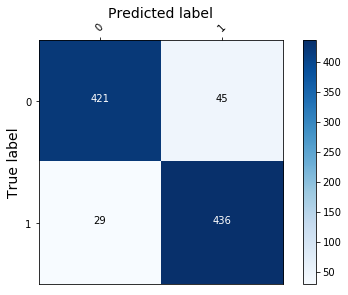

Accuracy =     0.921
Precision =     0.906
Recall (TPR) =  0.938
Fallout (FPR) = 0.097


In [26]:
SVM_cm.plot_confusion_matrix()
acc, pr, tpr, fpr = SVM_cm.show_data()

### Confusion matrix for linear SVC

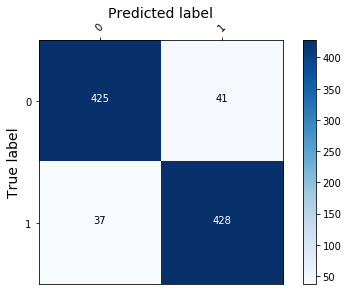

Accuracy =     0.916
Precision =     0.913
Recall (TPR) =  0.920
Fallout (FPR) = 0.088


In [32]:
LSVC_cm = ConfusionMatrix(LSVC_preds, y_test, LSVC_clf)
LSVC_cm.plot_confusion_matrix()
acc, pr, tpr, fpr = LSVC_cm.show_data()

### Cross validation on SGD SVM and Linear SVC

In [85]:
SVM_scores = cross_val_score(Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=0.0001, random_state=908,
                          max_iter=5, tol=None))]), X, y, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (SVM_scores.mean(), SVM_scores.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy: 0.92 (+/- 0.02)


In [87]:
LSVC_scores = cross_val_score(Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(random_state=908))
]), X, y, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (LSVC_scores.mean(), LSVC_scores.std() * 2))

Accuracy: 0.92 (+/- 0.02)


In [ ]:
### further discussion of text classification and model interpretation:
### https://medium.com/@chrisfotache/text-classification-in-python-pipelines-nlp-nltk-tf-idf-xgboost-and-more-b83451a327e0